In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [8]:
train = get_data('C:/Aman SDP/chest_xray/train')
test = get_data('C:/Aman SDP/chest_xray/test')
val = get_data('C:/Aman SDP/chest_xray/val')

In [10]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341
Pneumonia - Normal: 2534


PNEUMONIA


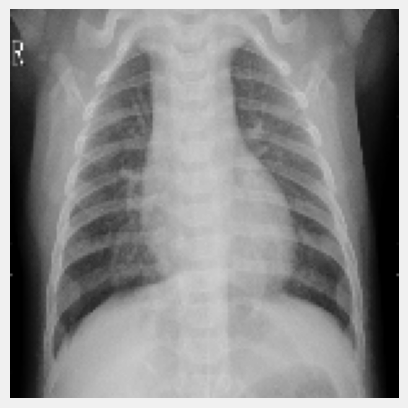

In [12]:
plt.imshow(train[1][0], cmap='gray')
plt.axis('off')
print(labels[train[1][1]])

In [13]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [14]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [15]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [16]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

c:\Users\rounak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 256)    │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 38, 38, 64)     │           152 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 19, 19, 16)     │            76 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       369,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,633 (2.02 MB)

 Trainable params: 529,369 (2.02 MB)

 Non-trainable params: 264 (1.03 KB)

In [18]:
history = model.fit(
    datagen.flow(
        X_train, y_train, 
        batch_size=10), 
        callbacks=[early_stop], 
        validation_data=(X_val, y_val), 
        epochs=15)

Epoch 1/15


c:\Users\rounak\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 116s 302ms/step - acc: 0.6534 - loss: 0.7941 - val_acc: 0.7407 - val_loss: 0.5640
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 118s 315ms/step - acc: 0.7280 - loss: 0.5491 - val_acc: 0.7577 - val_loss: 0.4225
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 121s 321ms/step - acc: 0.7537 - loss: 0.4661 - val_acc: 0.8122 - val_loss: 0.3973
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 122s 326ms/step - acc: 0.7907 - loss: 0.4319 - val_acc: 0.8591 - val_loss: 0.3330
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 318ms/step - acc: 0.8166 - loss: 0.3890 - val_acc: 0.8282 - val_loss: 0.3436
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 119s 318ms/step - acc: 0.8411 - loss: 0.3623 - val_acc: 0.8645 - val_loss: 0.2956
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 125s 334ms/step - acc: 0.8356 - loss: 0.3520 - val_acc: 0.8367 - val_loss: 0.3482
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 338ms/step - acc: 0.8661 - loss: 0.3139 - val_acc: 0.5977 - val_loss: 0.8110
Epoch 9/15
375/375 ━━━━━━━━━━━━━━━━

In [19]:
model.evaluate(X_test, y_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - acc: 0.8649 - loss: 0.2851


[0.3020499050617218, 0.8523890972137451]

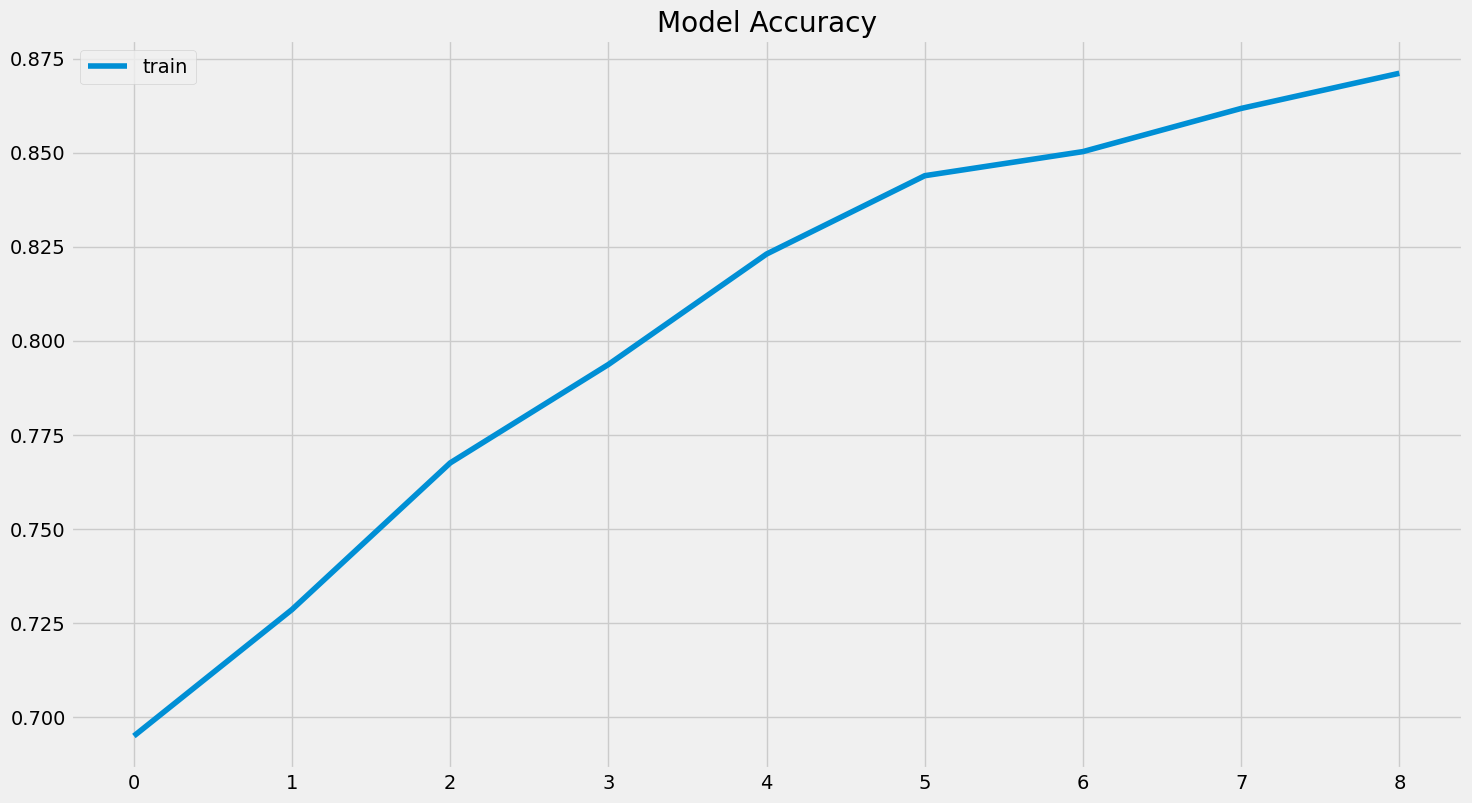

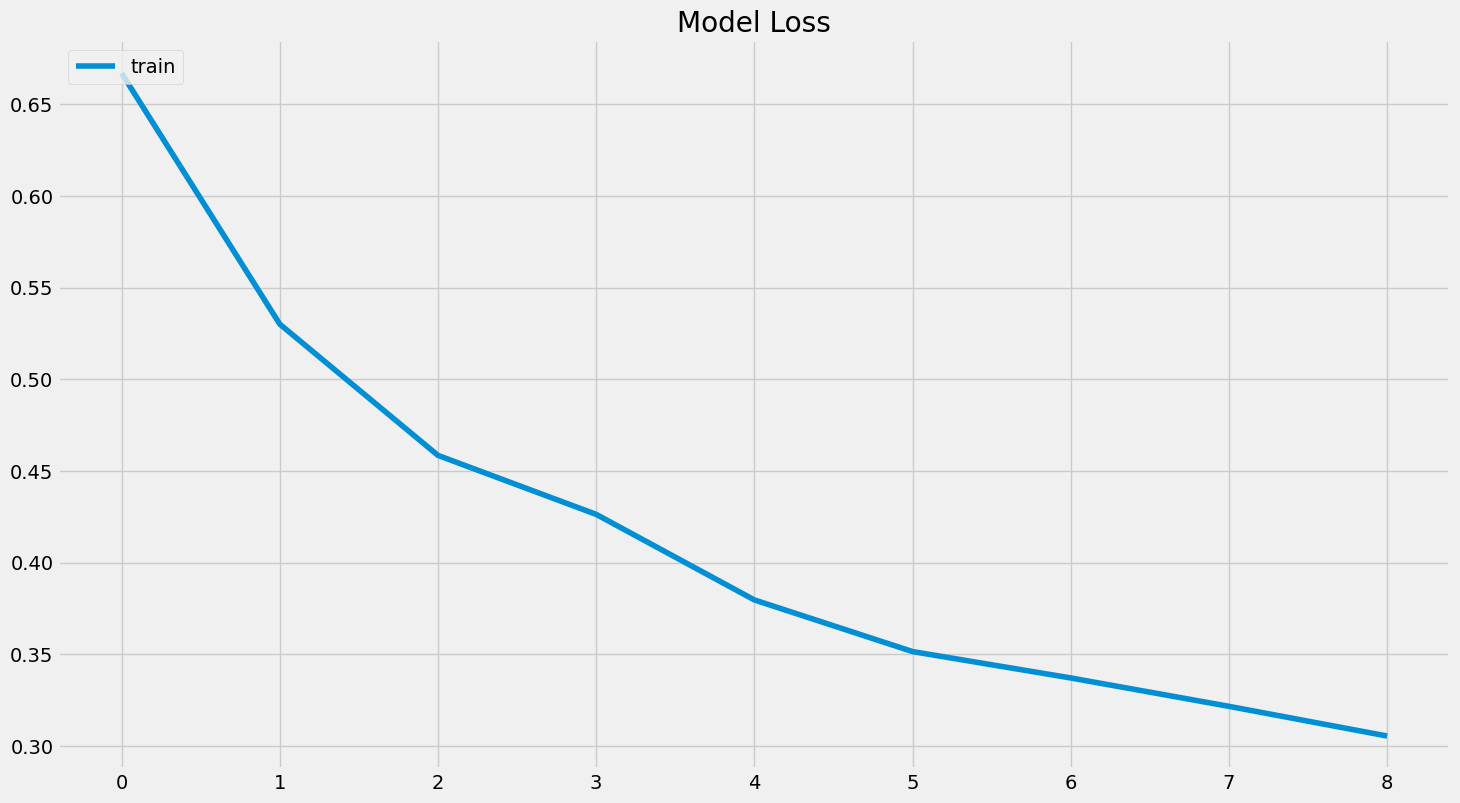

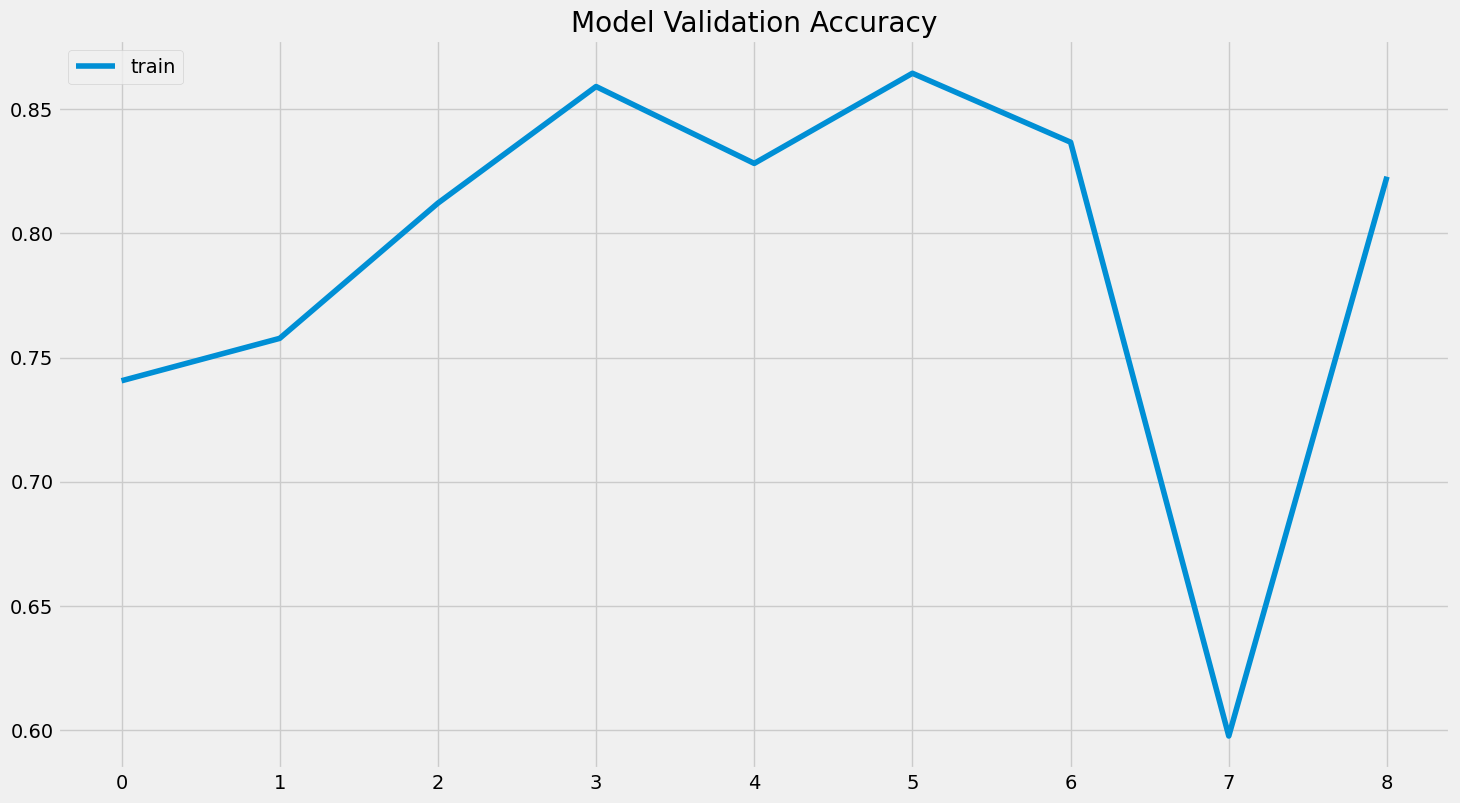

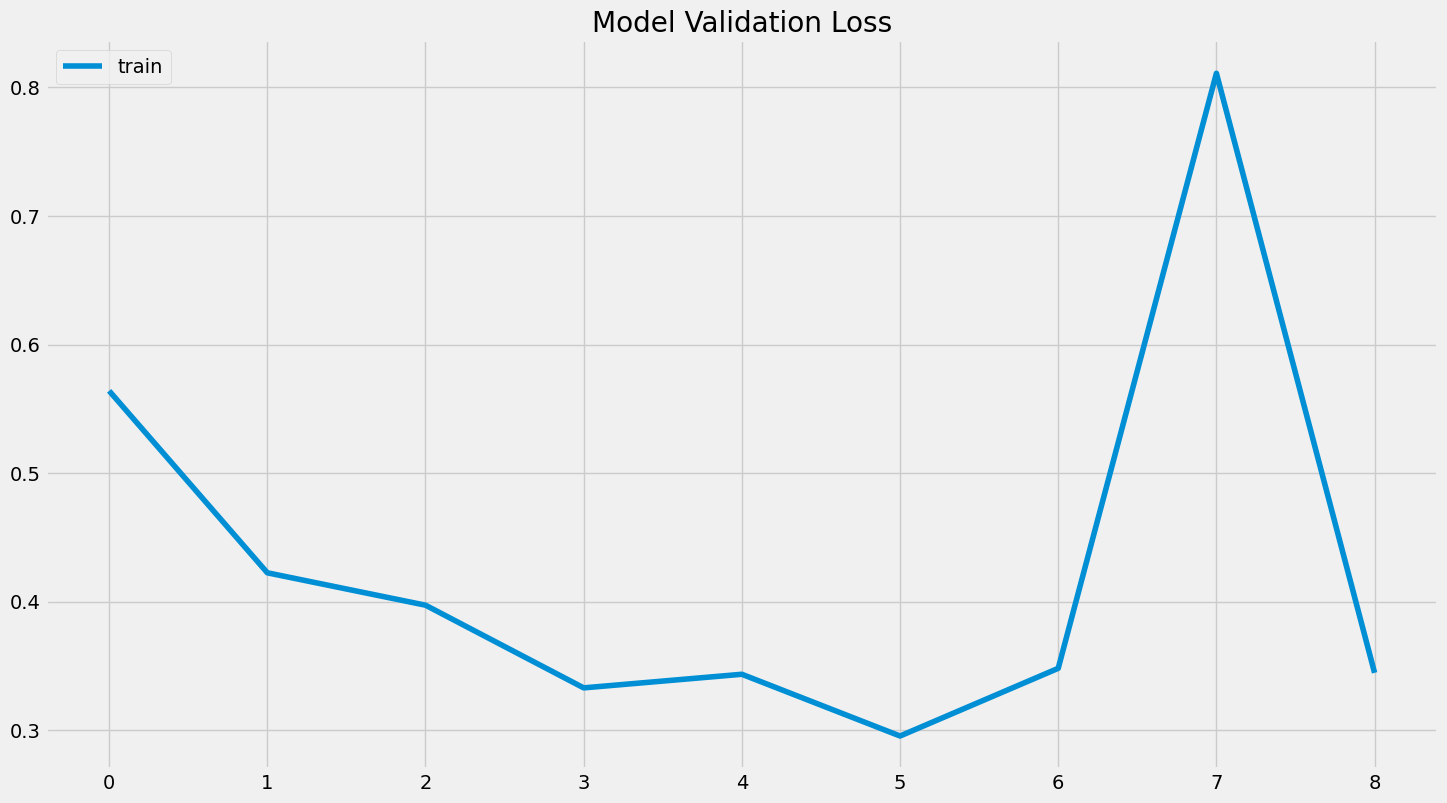

In [20]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [21]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 238ms/step


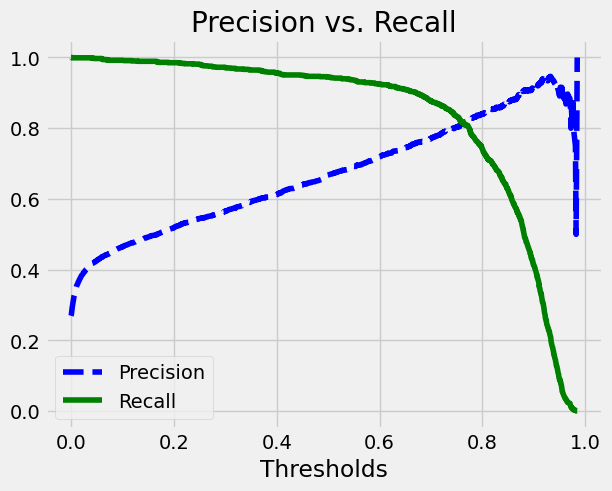

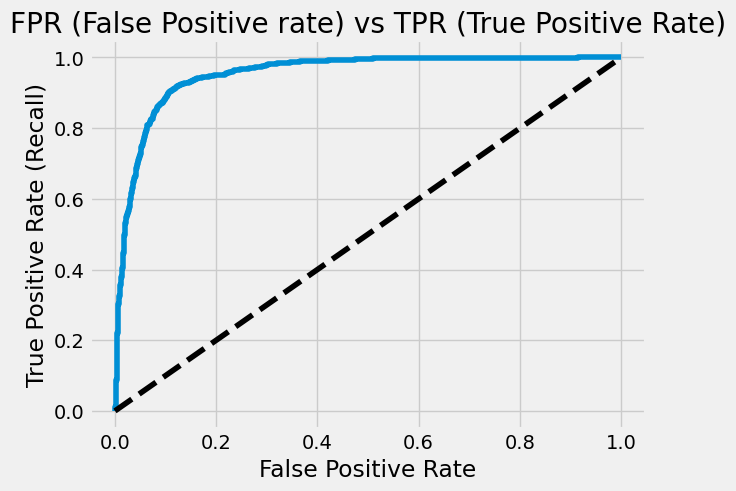

In [22]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [23]:
predictions = model.predict(X_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step


In [24]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [25]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9172354948805461
Precision on testing set: 0.8632218844984803
Recall on testing set: 0.8452380952380952


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

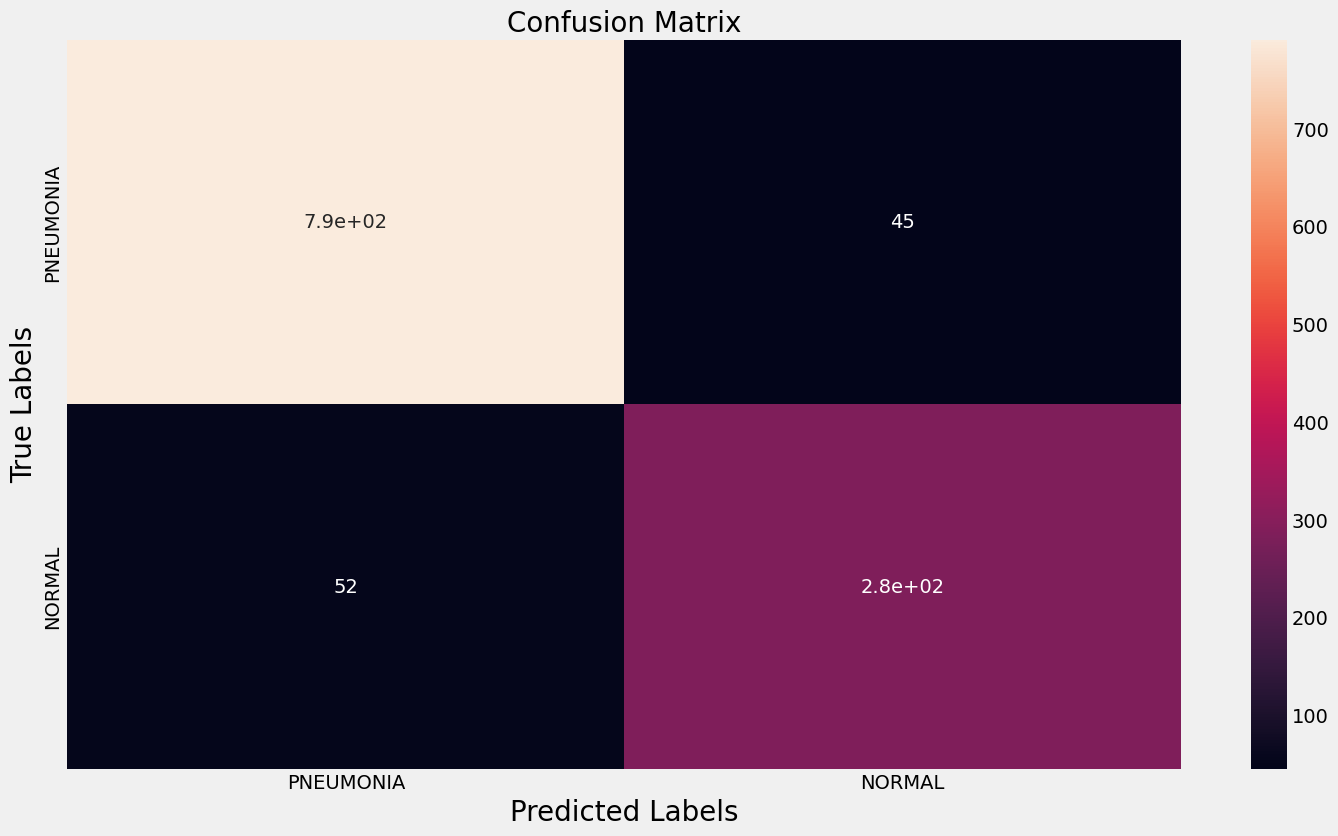

In [26]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

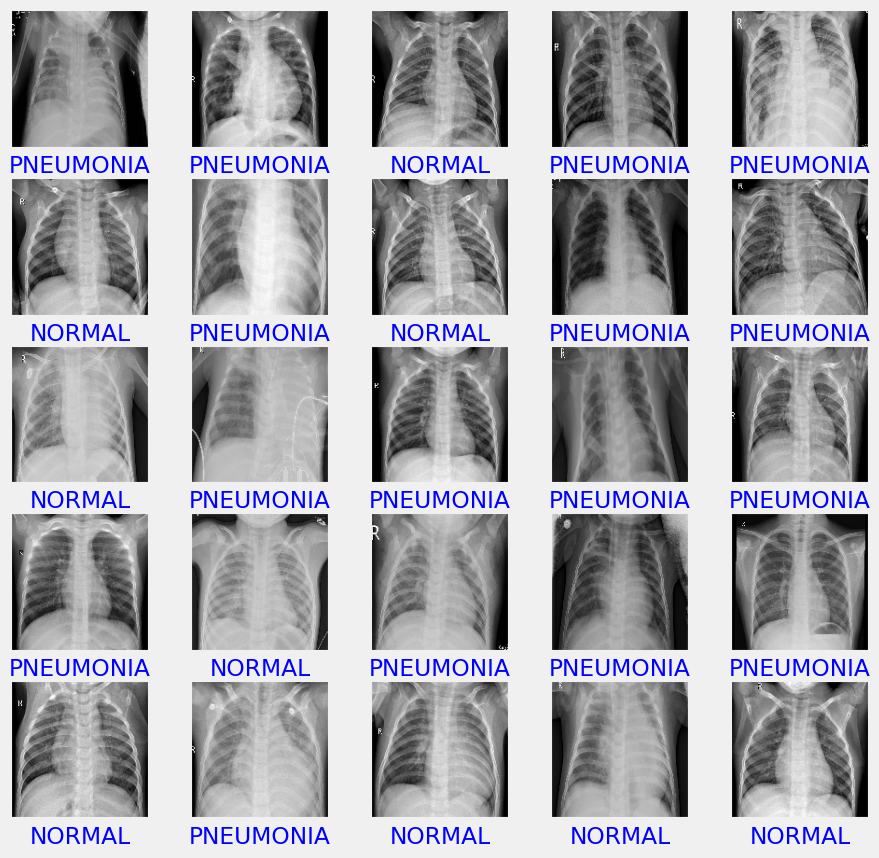

In [35]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()

In [36]:
 model.save('pneumonia_detection_ai_version_3.h5')

### Below I have tried to implement explainable AI using the LIME technique. 

There are various approaches to XAI, depending on the type of model and desired level of explanation:

Model-agnostic methods: These work for any model type and explain the relationship between inputs and outputs. Examples include feature importance analysis (identifying which features most influence the model's decision) and LIME (Locally Interpretable Model-Agnostic Explanations).
Model-specific methods: These leverage the internal structure of the model to provide explanations. For example, for decision trees, you can trace the path a data point takes through the tree to reach a prediction.
Benefits of XAI:

Increased Trust and Adoption: Transparent models can lead to wider adoption of AI in various sectors.
Improved Debugging and Model Development: Explanations can help pinpoint issues and guide model improvements.
Fairness and Bias Detection: XAI can help identify and mitigate potential biases in AI models.
Challenges of XAI:

Complexity of Explanations: Explaining complex models in an easily understandable way can be challenging.
Trade-off with Performance: Sometimes, making a model more explainable might come at the cost of reduced accuracy.
Overall, Explainable AI is an evolving field that aims to bridge the gap between black-box models and human understanding. By fostering trust, transparency, and responsible AI development, XAI plays a crucial role in the responsible integration of AI into various domains.

In [38]:
import lime
from lime import lime_image
from tensorflow.keras.preprocessing.image import img_to_array  # Assuming you use this for preprocessing


In [39]:
def explain_instance_with_lime(model, explainer, input_image):
  # Assumes input_image is a preprocessed image
  input_image = img_to_array(input_image)  # Convert to array if needed
  input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension

  # Explanation with LIME (modify for number of classes if needed)
  explanation = explainer.explain_instance(
      input_image, model.predict, top_labels=2, num_features=5
  )

  # Return explanation object or process further (e.g., extract top features)
  return explanation


Initial image shape: (1333, 1582, 3)


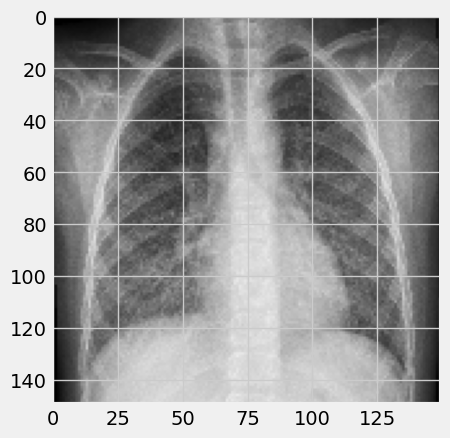

In [73]:
#Preprocessing the test Image for XAI 

import cv2
import numpy as np

# Assuming the downloaded image is a PNG
test_image_path = 'C:/Aman SDP/chest_xray/test/PNEUMONIA/person16_virus_47.jpeg'
test_img = cv2.imread(test_image_path)

print(f"Initial image shape: {test_img.shape}")

# # Convert to grayscale (if your model requires it)
# if (False):
#   test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Resize (if your model expects a specific size)
if (True):
  desired_size = (150, 150)  # Replace with your model's size
  test_img = cv2.resize(test_img, desired_size)

# Convert to float32 (if your model requires it)
if(True):
  test_img = test_img.astype(np.float32)

# Normalize (if your model expects normalized data)
if (True):
  test_img = test_img / 255.0
  
if (True):
  test_img = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)

# # Add batch dimension (if your model needs it)
# if your_model_needs_batch_dimension:
#   test_img = np.expand_dims(img, axis=0)


# # Now you have the preprocessed test_image for LIME explanation
# print(f"Final image shape: {test_img.shape}")  # Check the final shape
plt.imshow(test_img)

In [72]:

# Assuming you have a preprocessed test image (test_image)
explainer = lime_image.LimeImageExplainer()
explanation = explain_instance_with_lime(model, explainer, test_img)

# Access top features or explanation object for further processing
top_features = explanation.as_list()[0]  # Assuming top explanation
print(f"Top features contributing to prediction: {top_features}")

# Visualize explanation using LIME's built-in methods (optional)
explanation.save_to_file("explanation.jpg", test_img)


ValueError: Only 2D color images are supported